# LoRA Fine Tuning Gemma LLM with Keras and JAX
* Notebook by Adam Lang
* Date: 1/18/2025

# Overview
* In this project I will fine tune the Google Gemma LLM model using LoRA techique in Keras.
* Specifically we will use JAX as the backend rather than PyTorch or TensorfFlow

# Project Setup
1. Go to aistudio.google.com
  * Setup API key.

2. Go to "kaggle-gemma" via google search.
  * It will take you to the Google/Gemma page.
  * You need to consent to using the model, then you will be granted access to the model.

3. Kaggle Access
* You will also need to get your KAGGLE_USERNAME and KAGGLE_KEY from your personal kaggle account.
* You will need to generate a new KAGGLE token.


4. Runtime setup
  * T4 GPU is advisable for this on google colab, or if using runpod then consider GPU and PyTorch docker image you need.


# Setup Environment Variables

In [18]:
import os
from google.colab import userdata ##colab API

## environment variables
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Install Dependencies
* We will need:
1. Keras
2. KerasNLP --> docs: https://keras.io/getting_started/
3. other dependencies

In [19]:
## keras installation
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

# Select Backend
* Keras is a high-level, multi-framework deep learning API designed for simple and efficient use.
* Keras 3 is configured with 3 backend frameworks:
1. TensorFlow
2. JAX
3. PyTorch

* We will use JAX as the backend.

## Why JAX?
* JAX was developed by Google, is an open-source ML framework built on functional programming principles.
* JAX stands for **Just Another XLA** where **XLA stands for Accelerated Linear Algebra.**
  * JAX is becoming more popular for its numerical computation and automatic differentiation capabilities, which help in the development of many ML algorithms.
  
  * Although JAX is a relatively new ML framework, it has some helpful features for developing machine learning models.

### Features of JAX
* JAX can automatically differentiate functions using the **reverse-mode differentiation technique.**
  * This helps with seamless calculation of gradients and provides accurate values in training ML models.
* **JAX runs on CPU, GPU, and TPU, which provides faster numerical computations.**

* **JAX is compatible with NumPy and other Python libraries, making it easier to integrate existing Python codebases.**

* JAX uses built-in Just-In-Time (JIT) compilation which results in faster training time for ML models that involve complex computations.

* JAX is highly flexible!!!!!!!
  * You can create custom neural network architectures using JAX.

* JAX offers automatic parallelization and vectorization across multiple devices.


In [20]:
## setup JAX backend
os.environ["KERAS_BACKEND"] = "jax" ## or replace with "torch" or "tensorflow"

## to avoid memory fragmentation on JAX backend:
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

# Import Packages
* We need **Keras** and **KerasNLP**.

In [21]:
import keras
import keras_nlp

# Load Dataset
* To finetune a model with GEMMA, you need the data to be in JSON format, but specifically **JSONL** is desired.

## What is JSONL?
* JSONL or "JSON Lines" is a method to store structured data.
* Essentially it is a text file where each line contains a single, valid JSON object. * * This data type is very commonly used when fine-tuning a foundational LLM model such as Gemma.

1. Key Benefits
  * Easy to Read
    * Both humans and computers can easily parse JSONL.
  * Streaming
    Since each line is independent, it’s perfect for processing large datasets one object at a time without loading everything into memory.
  * Wide Application
    JSONL’s structure and efficiency make it a popular choice for tasks like fine-tuning LLMs.

2. Key Points
  * Each line represents a complete JSON object.
  * Ideal for handling large datasets or streaming data scenarios.
  * Commonly used for training and fine-tuning LLMs.

3. Data Problems JSONL solves
  * a) **Tabular data**
    * CSV has no standard encoding, no standard column separator and multiple character escaping standards. String is the only type supported for cell values, so some programs attempt to guess the correct type.
    * JSON Lines handles tabular data cleanly and without ambiguity. Cells may use the standard JSON types.

  * b) **Self-describing data**
    * JSON Lines enables applications to read objects **line-by-line**, with each line fully describing a JSON object.
    * The example below contains the same data as tabular data, but allows applications to **split files on newline boundaries for parallel loading, and eliminates any ambiguity if fields are omitted or re-ordered.**

```
{"name": "Gilbert", "session": "2013", "score": 24, "completed": true}
{"name": "Alexa", "session": "2013", "score": 29, "completed": true}
{"name": "May", "session": "2012B", "score": 14, "completed": false}
{"name": "Deloise", "session": "2012A", "score": 19, "completed": true}
```
  * c) **Nested Data**
    * JSON Lines' biggest strength is in handling lots of similar nested data structures.
    * **One `.jsonl` file is easier to work with than a directory full of XML files!!**

* Source docs: https://jsonlines.org/

## Dataset info
* The dataset used here: `databricks/databricks-dolly-15k`
* Dataset card from HF: https://huggingface.co/datasets/databricks/databricks-dolly-15k
* This is an open source dataset of instruction-following records generated by thousands of Databricks employees in several of the behavioral categories outlined in the original `InstructGPT paper`, including:

  1. brainstorming
  2. classification
  3. closed QA
  4. generation
  5. information extraction
  6. open QA
  7. summarization.



In [22]:
!wget --content-disposition 'https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl' -O databricks-dolly-15k.jsonl

--2025-01-19 16:18:06--  https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl
Resolving huggingface.co (huggingface.co)... 13.35.202.40, 13.35.202.34, 13.35.202.121, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.40|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/34/ac/34ac588cc580830664f592597bb6d19d61639eca33dc2d6bb0b6d833f7bfd552/2df9083338b4abd6bceb5635764dab5d833b393b55759dffb0959b6fcbf794ec?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27databricks-dolly-15k.jsonl%3B+filename%3D%22databricks-dolly-15k.jsonl%22%3B&Expires=1737562686&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNzU2MjY4Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8zNC9hYy8zNGFjNTg4Y2M1ODA4MzA2NjRmNTkyNTk3YmI2ZDE5ZDYxNjM5ZWNhMzNkYzJkNmJiMGI2ZDgzM2Y3YmZkNTUyLzJkZjkwODMzMzhiNGFiZDZiY2ViNTYzNTc2NGRhYjVkODMzYjM5M2I1NTc1OWRmZmIw

This code below will download the file in html format

In [23]:
#!rm databricks-dolly-15k.jsonl # Remove the existing file
#!wget -O databricks-dolly-15k.jsonl https://huggingface.co/datasets/databricks/databricks-dolly-15k # Re-download the file

# Pre-Processing Dataset
* To work with the dataset we are going to have to parse the file and format it for fine-tuning the LLM.
* We will use about 1000 training examples to make this run faster on the GPU and memory that we have, but obviously if you want to have a more accurate model you should use a large sample size.

## Parsing JSONL data
* This approach below is crucial for correctly processing a `.jsonl` file where **each line represents an independent JSON object.**
* The key here being that JSONL is a sequence of JSON objects, parsing JSON file usually the entire file is parsed at the same time.
* You need to process a JSONL file line by line, parsing each line individually as a JSON object using `json.loads().`
  * This is in contrast to parsing a regular JSON file, where you load the entire file content as a single JSON structure.
* By parsing each line individually, we ensure that the JSON data is loaded correctly for further use.

In [24]:
## parse file into json
import json

data = [] ## store in list
with open("databricks-dolly-15k.jsonl") as file:
  for line in file:
    features = json.loads(line)
    # Filter out examples with context to keep simple
    if features['context']:
      continue
    # format entire examples as single string
    template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
    data.append(template.format(**features))


## only use 1000 training examples for fine-tuning
data = data[:1000]

In [25]:
## view data first 100 index
data[0:100]

['Instruction:\nWhich is a species of fish? Tope or Rope\n\nResponse:\nTope',
 'Instruction:\nWhy can camels survive for long without water?\n\nResponse:\nCamels use the fat in their humps to keep them filled with energy and hydration for long periods of time.',
 "Instruction:\nAlice's parents have three daughters: Amy, Jessy, and what’s the name of the third daughter?\n\nResponse:\nThe name of the third daughter is Alice",
 'Instruction:\nWho gave the UN the land in NY to build their HQ\n\nResponse:\nJohn D Rockerfeller',
 'Instruction:\nWhy mobile is bad for human\n\nResponse:\nWe are always engaged one phone which is not good.',
 'Instruction:\nWhat is a polygon?\n\nResponse:\nA polygon is a form in Geometry.  It is a single dimensional plane made of connecting lines and any number of vertices.  It is a closed chain of connected line segments or edges.  The vertices of the polygon are formed where two edges meet.  Examples of polygons are hexagons, pentagons, and octagons.  Any plan

# Load LLM Model
* KerasNLP is an alternative to using HuggingFace. It does not replace it but offers an additional toolbox.
* The great thing about KerasNLP is that it provides numerous tools for fine-tuning open-source LLMs.
* Gemma in particular has a full framework we can use: https://keras.io/keras_hub/api/models/gemma/gemma_causal_lm/
* Since we are fine-tuning Gemma for generative AI tasks, we will use `GemmaCausalLM` to causal modeling.

## Load model from Kaggle using the `from_preset` method.
* Gemma model card from Kaggle: https://www.kaggle.com/models/google/gemma
* The `from_preset` method will init the model from the preset architecture and model weights.
  * The specific model loading below is `gemma_2b_en`.
  * There is also the `gemma_7b` model which would require more compute power and GPU access.

In [26]:
## create gemma model
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

# Testing out the Gemma Base Model
* We can test out the base model before we fine-tune it. This is always best practice in LLM fine-tuning to see what the raw capabilities of a model are before fine-tuning for specific tasks.

Test #1 - Travel related prompt

In [28]:
## create Zero-shot prompt
prompt = template.format(
    instruction="What should I do on a trip to Breckenridge, Colorado?",
    response="",
)
## Samplers allow us to control the statistical sampling used on the LLM
## more about samplers: https://keras.io/keras_hub/api/samplers/
## similar to "do_sample=True" setting in hugging face transformers
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=42)

# compile the model and generate response
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=400))

Instruction:
What should I do on a trip to Breckenridge, Colorado?

Response:
You should go to the Breckenridge Ski Area and take a ride on the Peak 8 Express Gondola. You can see the entire Breckenridge ski area from the top and you can see all the runs that they have there. You can also take a ride on the Breck Mountain Express Gondola, which takes you to the top of Peak 8. You can go to the top of Peak 8 and take a ride on the Peak 8 Gondola. You can take a ride on the Peak 8 Lift and then go to the top of Peak 10. You can ride the Breckenridge Ski Area Express Gondola to go to the top of the mountain, and then you can ride the Peak 10 Gondola.

Breckenridge Ski Resort has a lot of great runs, so you can take a ride up the Peak 8 Express Gondola and then take a lift down the mountain to go to the top of the mountain. You can then take a ride on the Peak 10 Gondola, which will take you to the top of the Peak 10 mountain.

If you're looking for a place to stay in Breckinridge, Colorad

Test #2 - Scientific related prompt

In [31]:
## create prompt
prompt = template.format(
    instruction="Please explain what stable diffusion is as if I were a 5th grader. In 3 bullet points.",
    response="",
)
## we will use the TopP sampler
sampler = keras_nlp.samplers.TopPSampler(p=0.7, k=1_000)
## compile model, generate response
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=300))

Instruction:
Please explain what stable diffusion is as if I were a 5th grader. In 3 bullet points.

Response:
Stable diffusion is a deep learning model that generates realistic images based on a description. It uses a convolutional neural network to generate high-resolution images that can be used for a variety of applications, including art creation, image manipulation, and more. The model uses a generative adversarial network (GAN) to train itself to generate more realistic images, and is trained on a large dataset of images. The resulting images are typically of high quality and can be used for a variety of purposes, including artistic creation and image manipulation.

The stability of the diffusion process is a critical aspect of the model, as it ensures that the generated images are consistent and coherent. The model is also trained on a large variety of images, which helps to ensure that it can generate a wide range of realistic images. Additionally, the model is trained using a

Summary
* So we can see the foundation model without fine-tuning has general capabilities but now we will fine-tune the model to get more specific task oriented outputs.

# LoRA Fine-Tuning Gemma-2b LLM
* In order to get more refined outputs from the Gemma model, we will use Low Rank Adaptation (LoRA) to fine tune the model using the Dataset I loaded above.
* LoRA rank will determine the dimensionality of trainable matrices that are added during the training process which controls the precision and expressiveness of fine-tuning adjustments needed.
* LoRA uses matrix decomposition to decompose the matrix into smaller components similar to SVD.
  * LoRA tracks the changes of a model and updates the final weights for fine-tuning making the process more computationally efficient.
* In short:
  * A HIGER RANK matrix results in:
    * MORE DETAILED changes
    * MORE TRAINABLE parameters
    * LESS computational overhead
* However, Less accuracy and precision is also possible because we are only training a small percentage of the model parameters.

## How to choose LoRA parameters?

### 1. Rank (r)
* There is not "magic number" for LoRA, but most people go off the **orignal LoRA paper which used `r=8` and works for most problems and might be called the "sweet spot".**
* Two things to remember:
  1. If your dataset is significantly different and more complex compared to the dataset on which the model was pretrained, then it is best practice to use a HIGH rank value:
    * e.g. `64–256`

  2. If the problem you’re adapting a pre-trained model to, is relatively simple and doesn’t involve a complex new dataset that the model hasn’t encountered before, it is best practice to use LOWER rank values:
    * e.g. `4-12`

* These experiments from lightning.ai show that increasing Rank value doesn't seem to do much if the the problem you are solving is not very complex:

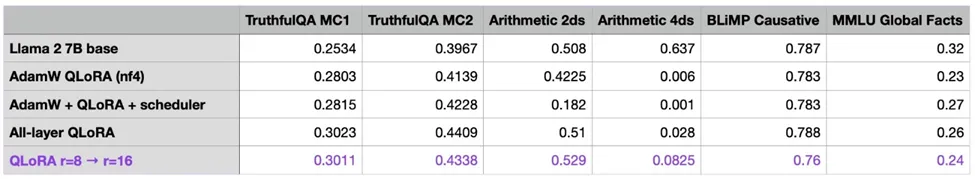

### 2. Alpha (a)
* General rule of thumb about alpha:
  1. HIGHER “alpha” would place more emphasis on the low-rank structure or regularization
  2. LOWER “alpha” would reduce its influence, making the model rely more on the original parameters.

* Adjusting “alpha” helps in finding a balance between fitting the data and preventing overfitting by regularizing the model.

#### How do we decide a good Alpha for your problem?
* Usually we choose an alpha value that is **twice as large as the rank when fine-tuning LLMs** (note that this is different when working with diffusion models).

* In the original LoRA paper, the authors use `α=16` for their experiments.


* Sources:
  * https://medium.com/@tayyibgondal2003/loralow-rank-adaptation-of-large-language-models-33f9d9d48984
  * https://arxiv.org/abs/2106.09685


## Setup LoRa and Rank
* Here we will choose a low rank of 4 as our fine-tuning task is "not that complex".

In [32]:
## 1. enable LoRA for model and set LoRA rank to 4
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,507,536,384 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,507,536,384 (9.34 GB)

 Trainable params: 1,363,968 (5.20 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

By enabling LoRA we reduced the number of trainable parameters from 2.5 billion to 1.3 million.


### Note about optimizer:
* We will use AdamW which is most commonly used for Generative LLM models.
* This is NOT the same as Adam optimizer.
  * Adam optimizer
    * weight decay is applied indirectly as part of the gradient update, which can unintentionally modify the learning dynamics and interfere with the optimization process.
  * AdamW
    * separates weight decay from the gradient step, ensuring regularization directly impacts the parameters without altering the adaptive learning mechanism.

* AdamW's design leads to **more precise regularization, helping models generalize better, particularly in tasks that involve large and complex datasets.***
* Thus it is important to remember that the two optimizers have very different use cases.
* [Good Review Article on Adam vs. AdamW](https://www.datacamp.com/tutorial/adamw-optimizer-in-pytorch)


### Note about Learning Rate
* A learning rate of 1e-4 has become the standard when fine-tuning LLMs with LoRA.
* Lowering the learning rate to 3e-5 or 5e-5 can stabilize training loss instabilities.
  * The goal is ultimately to prevent the loss from jumping up and down or wavering each time the model weights are updated during backpropagation of the neural network.



In [34]:
## 2. Limit input sequence length to 512 (reduce memory usage)
gemma_lm.preprocessor.sequence_length = 512

## 3. Use AdamW optimizer -- most common optimizer
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# 4. Exclude layernorm and bias terms from decay
optimizer.exclude_from_weight_decay(var_names=["bias","scale"])


# 5. Compile the model --
## 2 or more label classes use SparseCategoricalCrossEntropy
## We have 8 classes in the fine-tuning dataset
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
# 5. Fit model
gemma_lm.fit(data, epochs=1, batch_size=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1403s 1s/step - loss: 0.4585 - sparse_categorical_accuracy: 0.5238


# Note on mixed precision fine-tuning on NVIDIA GPUs
* Full precision is recommended for fine-tuning.
* When fine-tuning on NVIDIA GPUs, you can use mixed precision:
  * `keras.mixed_precision.set_global_policy('mixed_bfloat16')`
  * This will speed up training with minimal effect on overall training quality.
* Mixed precision fine-tuning does consume MORE MEMORY so us useful ONLY WITH LARGE GPUs.

For inference, half-precision(`keras.config.set_floatx("bfloat16")`) will work and save memory.

In [35]:
## if you want to enable mixed precision training for GPUs
# keras.mixed_precision.set_global_policy('mixed_bfloat16')

# Inference on Fine-Tuned Model
* Now that the model is fine-tuned, let's try to run inference using the original prompts we used above and evaluate the outputs.

## Test Prompt #1 -- Vacation Question

In [36]:
## Test Prompt #1 -- Vacation Question
prompt = template.format(
    instruction="What should I do on a trip to Breckenridge, Colorado?",
    response="",
)

sampler = keras_nlp.samplers.TopKSampler(k=5, seed=42)

# compile the model and generate response
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=400))

Instruction:
What should I do on a trip to Breckenridge, Colorado?

Response:
Breckenridge is a great place for outdoor enthusiasts to explore. There are many different activities you can do there, such as hiking, biking, skiing, and more. If you are looking for a more relaxing vacation, the town is also home to many spas and wellness centers. You could also visit the Breckenridge Museum of Mining and Science for a fascinating look at the history of mining in the area.


## Test Prompt #2 -- Vacation Question

In [37]:
## Test Prompt #2 -- Vacation Question
prompt = template.format(
    instruction="Please explain what stable diffusion is as if I were a 5th grader. In 3 bullet points.",
    response="",
)

sampler = keras_nlp.samplers.TopKSampler(k=5, seed=42)

# compile the model and generate response
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=400))

Instruction:
Please explain what stable diffusion is as if I were a 5th grader. In 3 bullet points.

Response:
Stable diffusion is a machine learning algorithm that uses deep learning and artificial intelligence to generate high-quality images. The algorithm uses a large database of images to train itself to recognize patterns and create new images based on those patterns.

Stable diffusion is often used to create realistic images of people, landscapes, and other objects. It can be used to create high-quality images for marketing, advertising, and other purposes.


Summary
* We can see the outputs were more succint and precise than without fine-tuning the model.

# Additional Things to try
1. Increase size of fine-tuning dataset
2. Train on more Epochs
3. Set LoRA rank higher than 4 and compare results.
4. Modify hyperparameters such as:
  * `learning_rate`
  * `weight_decay`
  * other params in Keras: https://keras.io/api/optimizers/adamw/